In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, utils
from PIL import Image
import os
import itertools
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
root_dir = "data"

In [4]:
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')

In [4]:
# Iterate over class folders in the data directory
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        print(f"Class: {class_name}")
        # Walk through all subdirectories
        for subdir, _, files in os.walk(class_path):
            resolution_count = {}
            total_images = 0
            for file in files:
                if file.lower().endswith(image_extensions):
                    try:
                        img_path = os.path.join(subdir, file)
                        with Image.open(img_path) as img:
                            resolution = img.size  # (width, height)
                            resolution_count[resolution] = resolution_count.get(resolution, 0) + 1
                            total_images += 1
                    except Exception as e:
                        print(f"Error opening {file}: {e}")
            if total_images > 0:
                subfolder_name = os.path.relpath(subdir, class_path)
                print(f"  Subfolder: {subfolder_name}")
                for res, count in resolution_count.items():
                    print(f"    Resolution: {res}, Count: {count}")

Class: apple2orange
  Subfolder: apple2orange\testA
    Resolution: (256, 256), Count: 266
  Subfolder: apple2orange\testB
    Resolution: (256, 256), Count: 248
  Subfolder: apple2orange\trainA
    Resolution: (256, 256), Count: 995
  Subfolder: apple2orange\trainB
    Resolution: (256, 256), Count: 1019
Class: cezanne2photo
  Subfolder: cezanne2photo\testA
    Resolution: (256, 256), Count: 58
  Subfolder: cezanne2photo\testB
    Resolution: (256, 256), Count: 751
  Subfolder: cezanne2photo\trainA
    Resolution: (256, 256), Count: 525


KeyboardInterrupt: 

Triedy ktoré nemajú konzistentné rozlíšenie:cityscapes,iphone2dslr_flower,maps,

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparametre

In [26]:
IMG_SIZE = 64
BATCH_SIZE = 16
LR = 0.0002
EPOCHS = 10
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 5.0
path_to_dataset="data/horse2zebra/horse2zebra"

In [27]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train', max_samples=None):
        self.transform = transform
        self.root = root
        self.mode = mode
        self.files_A = sorted(os.listdir(os.path.join(root, f"{mode}A")))
        self.files_B = sorted(os.listdir(os.path.join(root, f"{mode}B")))
        if max_samples:
            self.files_A = self.files_A[:max_samples]
            self.files_B = self.files_B[:max_samples]
        self.path_A = os.path.join(root, f"{mode}A")
        self.path_B = os.path.join(root, f"{mode}B")

    def __getitem__(self, index):
        img_A = Image.open(os.path.join(self.path_A, self.files_A[index % len(self.files_A)])).convert("RGB")
        img_B = Image.open(os.path.join(self.path_B, self.files_B[index % len(self.files_B)])).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


In [28]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Generator

In [29]:
# models.py
#  self attention helps the model learn long-range dependencies, especially useful for style transfer and texture consistency.
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key   = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)  # B x N x C'
        proj_key   = self.key(x).view(B, -1, H * W)                     # B x C' x N
        energy = torch.bmm(proj_query, proj_key)                       # B x N x N
        attention = torch.softmax(energy, dim=-1)                      # B x N x N
        proj_value = self.value(x).view(B, -1, H * W)                  # B x C x N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))        # B x C x N
        out = out.view(B, C, H, W)
        return self.gamma * out + x


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residuals=6):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):  # 64 → 32 → 16
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(num_residuals):
            model += [ResidualBlock(in_features)]
        model += [SelfAttention(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):  # 16 → 32 → 64
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features // 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, kernel_size=7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


### Discriminator

In [30]:
# models.py (continued)
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),  # (64x64) -> (32x32)
            *discriminator_block(64, 128),  # -> (16x16)
            *discriminator_block(128, 256),  # -> (8x8)
            *discriminator_block(256, 512),  # -> (4x4)
            nn.Conv2d(512, 1, kernel_size=4, padding=1)  # Output patch size (3x3 or so)
        )

    def forward(self, x):
        return self.model(x)


### Loss functions

In [31]:
adversarial_criterion = nn.MSELoss()
cycle_criterion = nn.L1Loss()
identity_criterion = nn.L1Loss()

In [32]:
G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Optimizers
g_optimizer = optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), 
    lr=LR, betas=(0.5, 0.999)
)
d_A_optimizer = optim.Adam(D_A.parameters(), lr=LR, betas=(0.5, 0.999))
d_B_optimizer = optim.Adam(D_B.parameters(), lr=LR, betas=(0.5, 0.999))

### Training loop

In [33]:
def train(dataloader):
    for epoch in range(EPOCHS):
        for i, batch in enumerate(dataloader):
            real_A = batch["A"].to(device)
            real_B = batch["B"].to(device)

            # -----------------------------------
            #  Train Generators G_AB and G_BA
            # -----------------------------------
            g_optimizer.zero_grad()

            # Identity loss
            same_B = G_AB(real_B)
            loss_identity_B = identity_criterion(same_B, real_B) * LAMBDA_IDENTITY

            same_A = G_BA(real_A)
            loss_identity_A = identity_criterion(same_A, real_A) * LAMBDA_IDENTITY

            # GAN loss
            fake_B = G_AB(real_A)
            pred_fake_B = D_B(fake_B)
            loss_GAN_AB = adversarial_criterion(pred_fake_B, torch.ones_like(pred_fake_B))

            fake_A = G_BA(real_B)
            pred_fake_A = D_A(fake_A)
            loss_GAN_BA = adversarial_criterion(pred_fake_A, torch.ones_like(pred_fake_A))

            # Cycle loss
            recov_A = G_BA(fake_B)
            loss_cycle_A = cycle_criterion(recov_A, real_A)

            recov_B = G_AB(fake_A)
            loss_cycle_B = cycle_criterion(recov_B, real_B)

            # Total generator loss
            g_loss = (loss_GAN_AB + loss_GAN_BA) + \
                     LAMBDA_CYCLE * (loss_cycle_A + loss_cycle_B) + \
                     (loss_identity_A + loss_identity_B)

            g_loss.backward()
            g_optimizer.step()

            # -----------------------------------
            #  Train Discriminator A
            # -----------------------------------
            d_A_optimizer.zero_grad()

            pred_real = D_A(real_A)
            loss_D_real = adversarial_criterion(pred_real, torch.ones_like(pred_real))

            pred_fake = D_A(fake_A.detach())
            loss_D_fake = adversarial_criterion(pred_fake, torch.zeros_like(pred_fake))

            d_A_loss = (loss_D_real + loss_D_fake) * 0.5
            d_A_loss.backward()
            d_A_optimizer.step()

            # -----------------------------------
            #  Train Discriminator B
            # -----------------------------------
            d_B_optimizer.zero_grad()

            pred_real = D_B(real_B)
            loss_D_real = adversarial_criterion(pred_real, torch.ones_like(pred_real))

            pred_fake = D_B(fake_B.detach())
            loss_D_fake = adversarial_criterion(pred_fake, torch.zeros_like(pred_fake))

            d_B_loss = (loss_D_real + loss_D_fake) * 0.5
            d_B_loss.backward()
            d_B_optimizer.step()

            # Logging
            if i % 100 == 0:
                print(
                    f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(dataloader)}] "
                    f"[D_A Loss: {d_A_loss.item():.4f}] [D_B Loss: {d_B_loss.item():.4f}] "
                    f"[G Loss: {g_loss.item():.4f}]"
                )


In [34]:


dataset = ImageDataset(path_to_dataset, transform=transform,max_samples=100)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
train(dataloader)

[Epoch 0/10] [Batch 0/7] [D_A Loss: 0.8090] [D_B Loss: 0.6964] [G Loss: 16.5500]
[Epoch 1/10] [Batch 0/7] [D_A Loss: 0.2884] [D_B Loss: 0.2676] [G Loss: 11.3915]
[Epoch 2/10] [Batch 0/7] [D_A Loss: 0.2362] [D_B Loss: 0.2429] [G Loss: 11.2868]
[Epoch 3/10] [Batch 0/7] [D_A Loss: 0.2193] [D_B Loss: 0.2668] [G Loss: 10.0675]
[Epoch 4/10] [Batch 0/7] [D_A Loss: 0.3006] [D_B Loss: 0.3244] [G Loss: 10.2998]
[Epoch 5/10] [Batch 0/7] [D_A Loss: 0.1717] [D_B Loss: 0.2165] [G Loss: 9.5372]
[Epoch 6/10] [Batch 0/7] [D_A Loss: 0.1943] [D_B Loss: 0.1802] [G Loss: 9.1763]
[Epoch 7/10] [Batch 0/7] [D_A Loss: 0.1721] [D_B Loss: 0.1273] [G Loss: 9.1224]
[Epoch 8/10] [Batch 0/7] [D_A Loss: 0.2020] [D_B Loss: 0.2445] [G Loss: 10.3052]
[Epoch 9/10] [Batch 0/7] [D_A Loss: 0.1499] [D_B Loss: 0.1173] [G Loss: 10.5160]


In [35]:
test_dataset = ImageDataset(path_to_dataset, transform=transform, mode='test', max_samples=50
                           )
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [36]:
def show_images(real, fake, title="Input vs Output"):
    real = real * 0.5 + 0.5
    fake = fake * 0.5 + 0.5

    images = torch.cat([real, fake], dim=3)
    grid = make_grid(images, nrow=1)

    np_img = grid.permute(1, 2, 0).detach().cpu().numpy()
    plt.figure(figsize=(6, 3))
    plt.imshow(np_img)
    plt.axis("off")
    plt.title(title)
    plt.show()


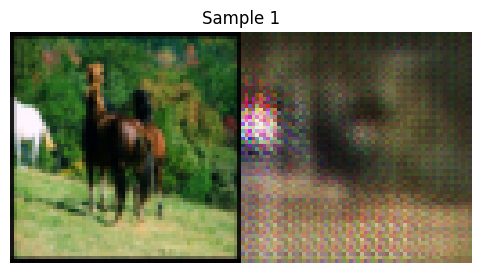

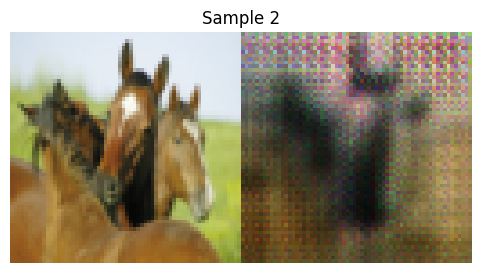

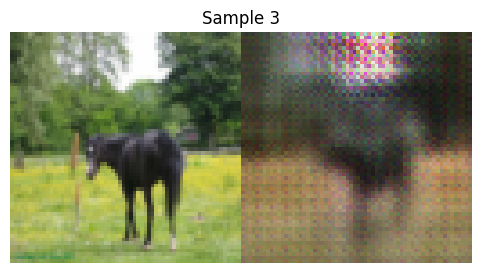

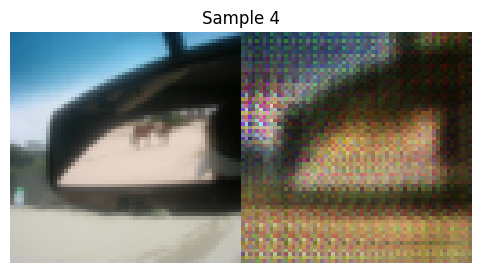

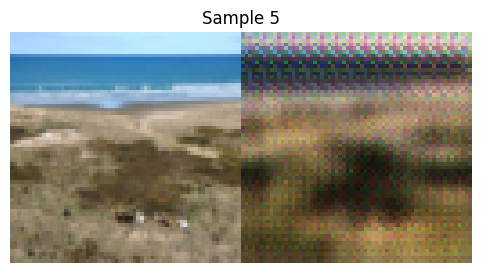

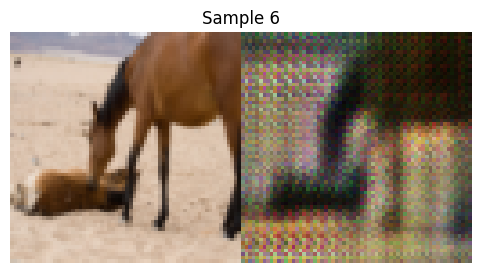

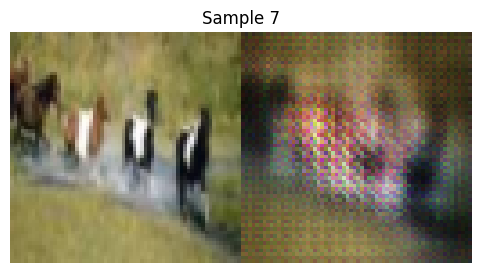

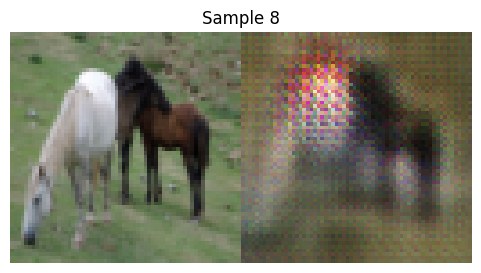

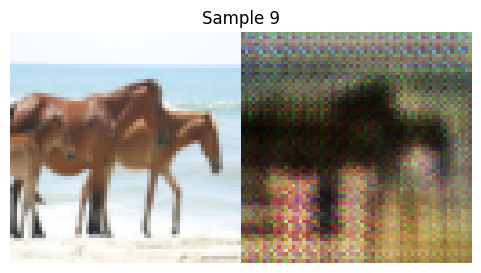

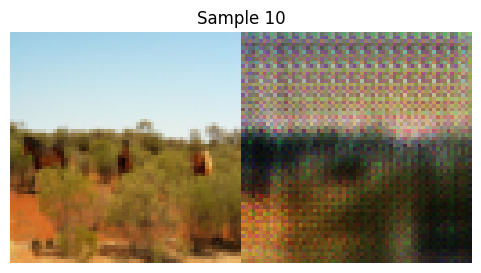

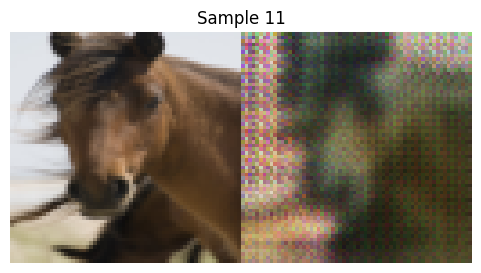

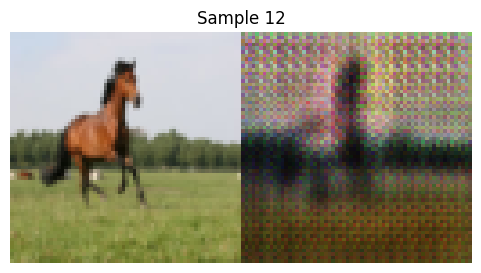

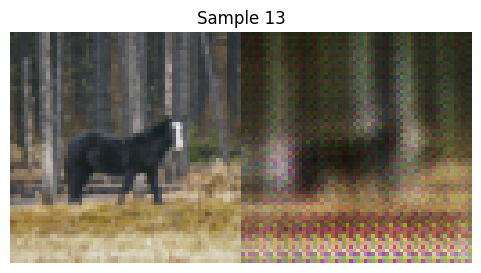

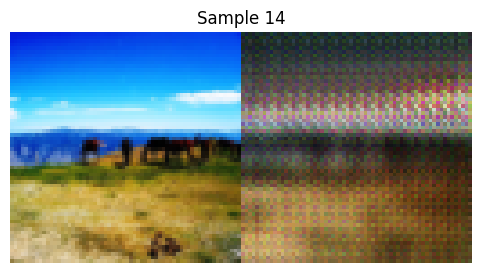

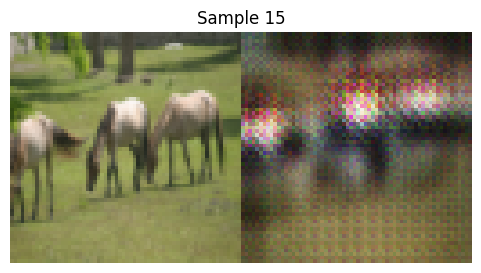

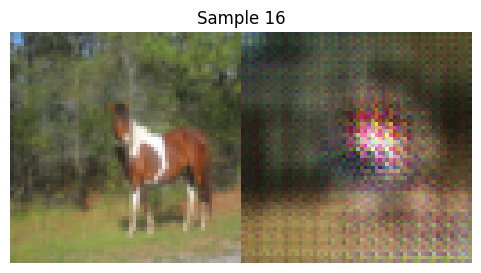

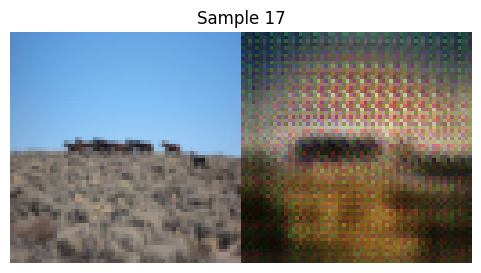

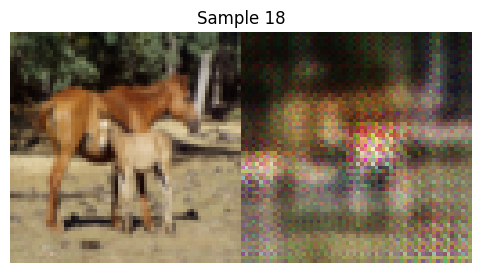

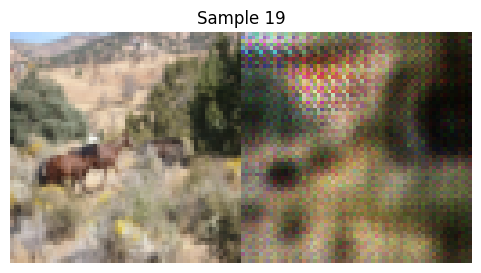

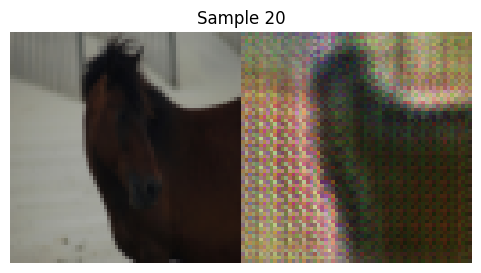

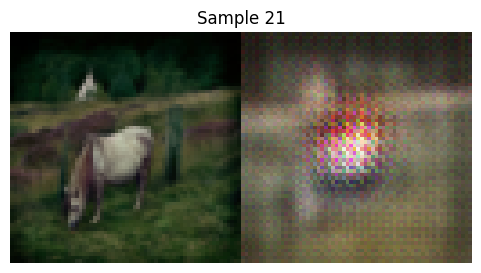

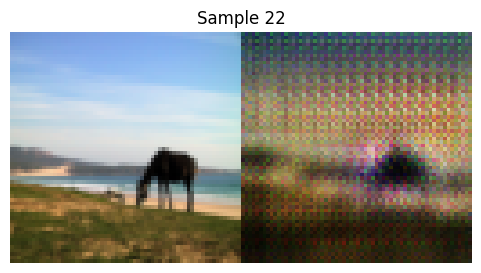

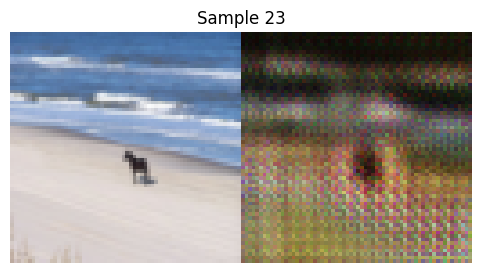

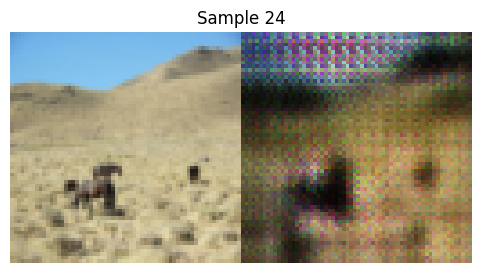

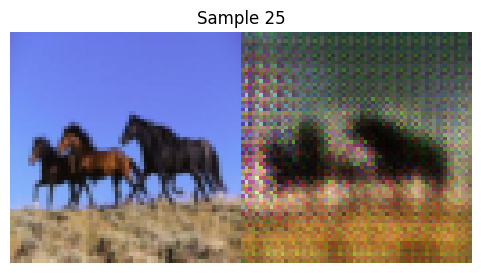

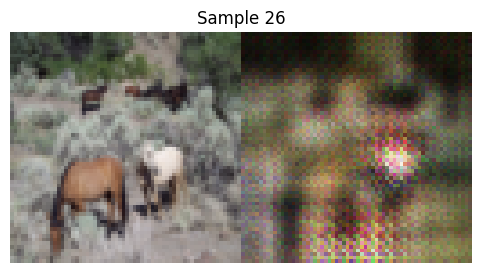

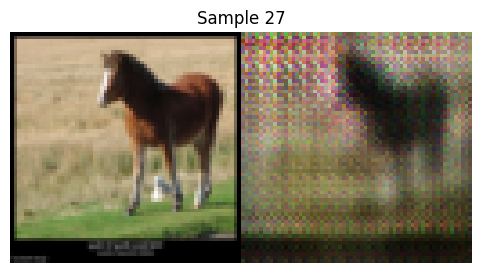

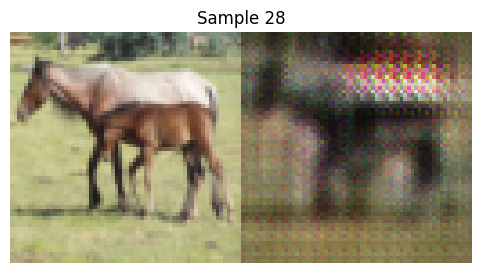

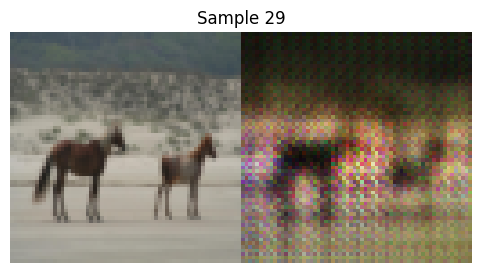

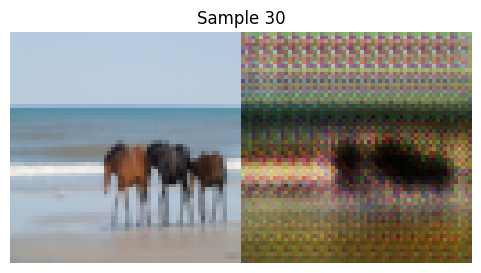

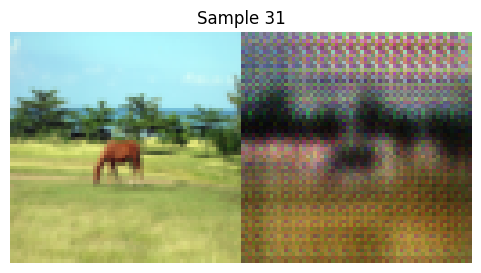

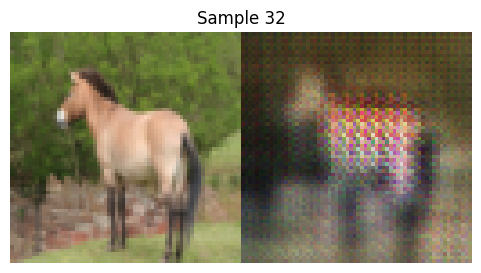

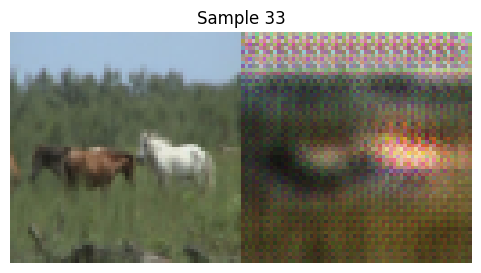

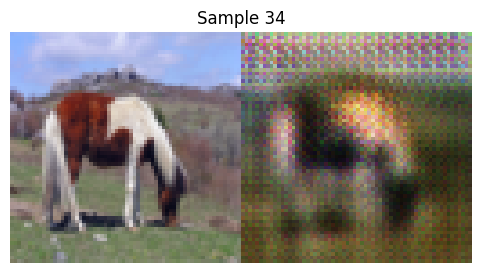

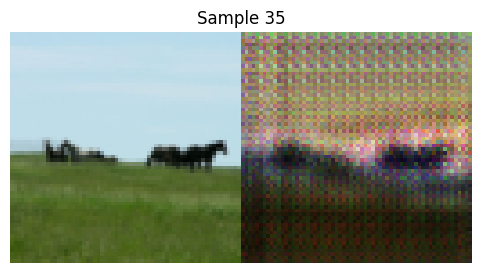

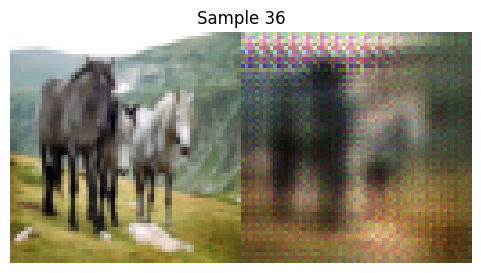

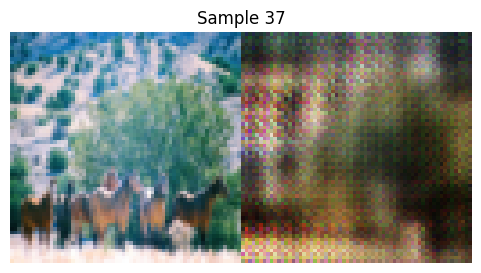

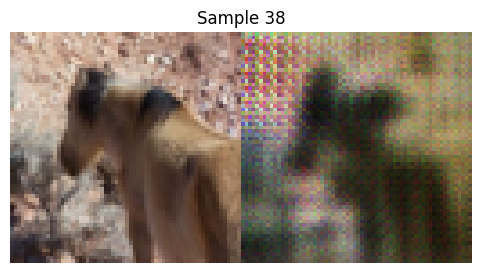

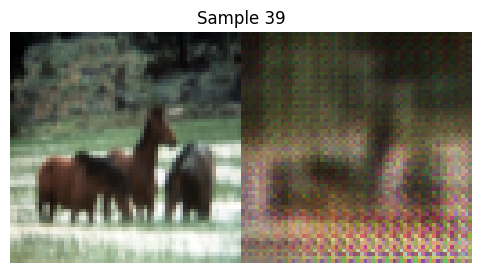

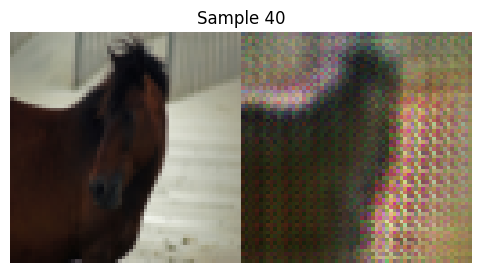

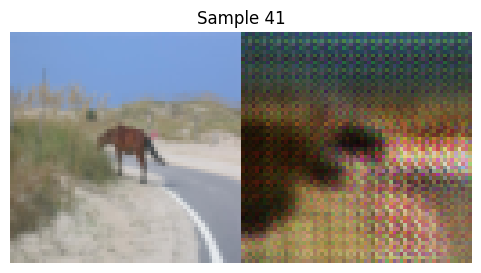

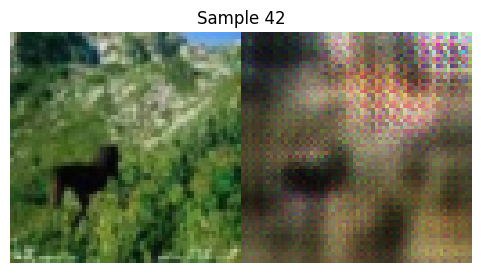

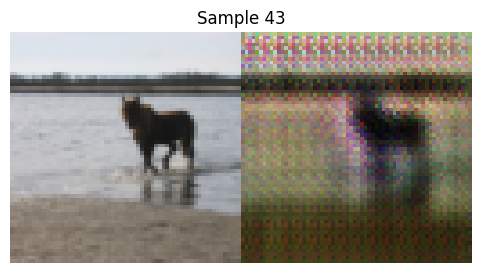

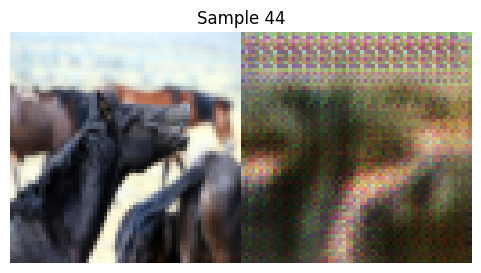

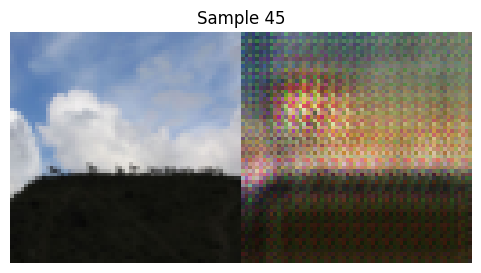

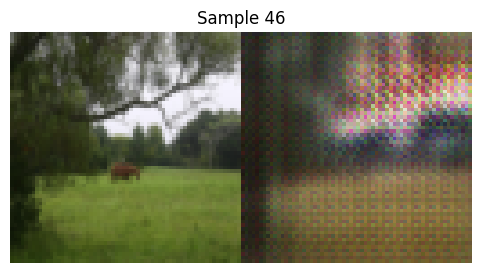

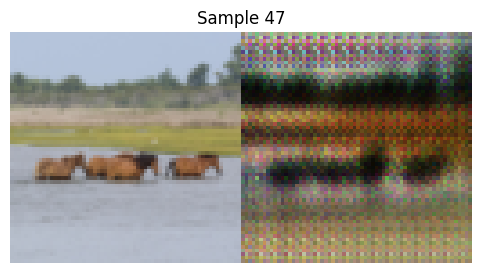

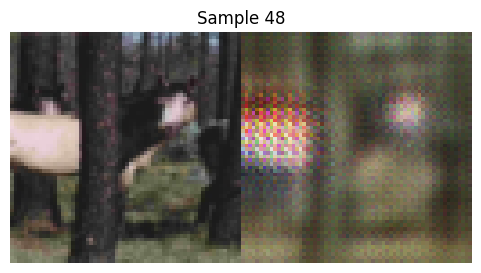

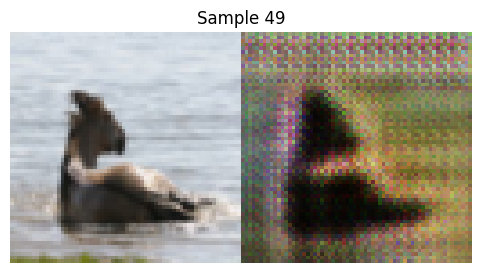

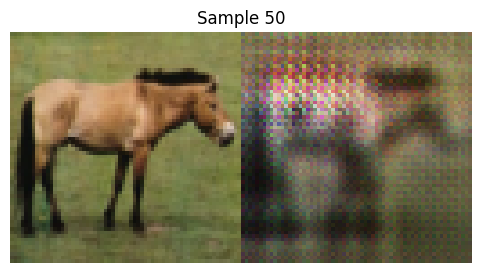

In [37]:
G_AB.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        real_A = batch["A"].to(device)
        fake_B = G_AB(real_A)
        show_images(real_A, fake_B, title=f"Sample {i+1}")


## AMS cycleGAN

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
IMG_SIZE = 64
EPOCHS = 30
LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 5
LAMBDA_STYLE = 10
LEARNING_RATE = 0.0002
DROPOUT = 0.5
path_to_dataset="data/horse2zebra/horse2zebra"

In [14]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
])

### Dataset

In [15]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode="train", max_samples=None):
        self.transform = transform
        self.files_A = sorted(os.listdir(os.path.join(root, f"{mode}A")))
        self.files_B = sorted(os.listdir(os.path.join(root, f"{mode}B")))
        if max_samples:
            self.files_A = self.files_A[:max_samples]
            self.files_B = self.files_B[:max_samples]
        self.path_A = os.path.join(root, f"{mode}A")
        self.path_B = os.path.join(root, f"{mode}B")

    def __getitem__(self, index):
        img_A = Image.open(os.path.join(self.path_A, self.files_A[index % len(self.files_A)])).convert("RGB")
        img_B = Image.open(os.path.join(self.path_B, self.files_B[index % len(self.files_B)])).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


In [16]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


In [17]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),
            ResnetBlock(256),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [19]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, h * w)
    gram = torch.bmm(features, features.transpose(1, 2))
    return gram / (c * h * w)

def style_loss(fake, real):
    return F.l1_loss(gram_matrix(fake), gram_matrix(real))

# Display Function
def show_images(real, fake, title="Input vs Output"):
    real = real * 0.5 + 0.5
    fake = fake * 0.5 + 0.5
    images = torch.cat([real, fake], dim=3)
    grid = make_grid(images, nrow=1)
    np_img = grid.permute(1, 2, 0).detach().cpu().numpy()
    plt.figure(figsize=(6, 3))
    plt.imshow(np_img)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [20]:
G_AB = Generator().to(DEVICE)
G_BA = Generator().to(DEVICE)
D_A = Discriminator().to(DEVICE)
D_B = Discriminator().to(DEVICE)

# Loss functions
adversarial_criterion = nn.MSELoss()
cycle_criterion = nn.L1Loss()
identity_criterion = nn.L1Loss()

# Optimizers
g_optimizer = torch.optim.Adam(
    list(G_AB.parameters()) + list(G_BA.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999)
)
d_optimizer_A = torch.optim.Adam(D_A.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
d_optimizer_B = torch.optim.Adam(D_B.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Load Dataset
dataset = ImageDataset(path_to_dataset, transform=transform, mode="train", max_samples=200)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
for epoch in range(EPOCHS):
    for i, batch in enumerate(dataloader):
        real_A = batch["A"].to(DEVICE)
        real_B = batch["B"].to(DEVICE)

        # Train Generators
        g_optimizer.zero_grad()

        same_B = G_AB(real_B)
        loss_identity_B = identity_criterion(same_B, real_B) * LAMBDA_IDENTITY

        same_A = G_BA(real_A)
        loss_identity_A = identity_criterion(same_A, real_A) * LAMBDA_IDENTITY

        fake_B = G_AB(real_A)
        pred_fake_B = D_B(fake_B)
        loss_GAN_AB = adversarial_criterion(pred_fake_B, torch.ones_like(pred_fake_B))

        fake_A = G_BA(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_BA = adversarial_criterion(pred_fake_A, torch.ones_like(pred_fake_A))

        recov_A = G_BA(fake_B)
        loss_cycle_A = cycle_criterion(recov_A, real_A)

        recov_B = G_AB(fake_A)
        loss_cycle_B = cycle_criterion(recov_B, real_B)

        loss_style_B = style_loss(fake_B, real_B)
        loss_style_A = style_loss(fake_A, real_A)

        g_loss = (loss_GAN_AB + loss_GAN_BA) + \
                 LAMBDA_CYCLE * (loss_cycle_A + loss_cycle_B) + \
                 (loss_identity_A + loss_identity_B) + \
                 LAMBDA_STYLE * (loss_style_A + loss_style_B)

        g_loss.backward()
        g_optimizer.step()

        # Train Discriminator A
        d_optimizer_A.zero_grad()
        pred_real = D_A(real_A)
        pred_fake = D_A(fake_A.detach())
        d_loss_A = (adversarial_criterion(pred_real, torch.ones_like(pred_real)) +
                    adversarial_criterion(pred_fake, torch.zeros_like(pred_fake))) * 0.5
        d_loss_A.backward()
        d_optimizer_A.step()

        # Train Discriminator B
        d_optimizer_B.zero_grad()
        pred_real = D_B(real_B)
        pred_fake = D_B(fake_B.detach())
        d_loss_B = (adversarial_criterion(pred_real, torch.ones_like(pred_real)) +
                    adversarial_criterion(pred_fake, torch.zeros_like(pred_fake))) * 0.5
        d_loss_B.backward()
        d_optimizer_B.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Generator Loss: {g_loss.item():.4f}")

Epoch [1/30] - Generator Loss: 14.6333
Epoch [2/30] - Generator Loss: 13.8697
Epoch [3/30] - Generator Loss: 11.8583
Epoch [4/30] - Generator Loss: 11.0442
Epoch [5/30] - Generator Loss: 10.7294
Epoch [6/30] - Generator Loss: 9.8727
Epoch [7/30] - Generator Loss: 9.9424
Epoch [8/30] - Generator Loss: 9.8504
Epoch [9/30] - Generator Loss: 9.7004
Epoch [10/30] - Generator Loss: 9.7594
Epoch [11/30] - Generator Loss: 9.8354
Epoch [12/30] - Generator Loss: 10.0196
Epoch [13/30] - Generator Loss: 9.3256
Epoch [14/30] - Generator Loss: 9.4389


KeyboardInterrupt: 

In [ ]:
test_dataset = ImageDataset(path_to_dataset, transform=transform, mode="test", max_samples=10)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

G_AB.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        real_A = batch["A"].to(DEVICE)
        fake_B = G_AB(real_A)
        show_images(real_A, fake_B, title=f"AMS-CycleGAN Output {i+1}")